Extracting info from the txt out files

In [1]:
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Funvtion to extract information from .txt files
def extract_info(file_path):
    data = []
    current_level = None
    sparsity = None
    first_epoch = None
    last_epoch = None

    with open(file_path, 'r') as file:
        for line in file:
            # Extract level
            level_match = re.search(r'current level: (\d+)/12', line)
            if level_match:
                if current_level is not None:
                    data.append([current_level, sparsity, first_epoch, last_epoch])
                current_level = int(level_match.group(1))
                first_epoch = None
                last_epoch = None

            # Extract sparsity
            if '_UM.txt'or '_rand.txt' in file_path:
                sparsity_match = re.search(r'from unpruned neurons, sparsity: (\d+(?:\.\d+)?)%', line)
            elif '_pmag.txt' in file_path:
                sparsity_match = re.search(r'identifying the lowest (\d+(?:\.\d+)?)% weights to prune', line) 
            if sparsity_match:
                sparsity = float(sparsity_match.group(1))

            # Extract epoch information
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\].*Test Accuracy: (\d+\.\d+)%', line)
            if epoch_match:
                epoch_num = int(epoch_match.group(1))
                accuracy = float(epoch_match.group(2))
                if epoch_num == 1:
                    first_epoch = accuracy
                last_epoch = accuracy

            # Check for training completion
            if "Training completed" in line and current_level is not None:
                data.append([current_level, sparsity, first_epoch, last_epoch])
                current_level = None
                sparsity = None

    return pd.DataFrame(data, columns=['level', 'sparsity', 'first epoch', 'last epoch'])

# Loading the .json files containing the unit_mem information for both methods    
def load_dict_from_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

# Getting average unit_mem per level for 
def calculate_average_per_level(pmag_dict):
    averages = {}
    for level, layer_dict in pmag_dict.items():
        level_values = []
        for layer_name, data in layer_dict.items():
            # Extract the first column (relevance values)
            relevance_values = [item[0] for item in data]
            level_values.extend(relevance_values)
        
        # Calculate the average for this level
        if level_values:
            averages[level] = np.mean(level_values)
        else:
            averages[level] = 0  # or None, depending on how you want to handle empty levels
    
    return averages

In [ ]:
def plot_accuracies(acc_highUM, acc_lowUM, acc_hybridUM ,pmag_path, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    df_prunemag = extract_info(pmag_path)
    df_h_unitmem = extract_info(acc_highUM)
    df_l_unitmem = extract_info(acc_lowUM)
    df_hy_unitmem = extract_info(acc_hybridUM)

    sparsity_df = pd.concat([df_h_unitmem['sparsity'], 
                            df_h_unitmem['last epoch'].rename('h_unitmem_acc'), 
                            df_l_unitmem['last epoch'].rename('l_unitmem_acc'),
                            df_hy_unitmem['last epoch'].rename('hy_unitmem_acc'),
                            df_prunemag['last epoch'].rename('pmag_acc')],
                            axis=1)

    ax.plot(sparsity_df['sparsity'], sparsity_df['h_unitmem_acc'], label='Highest UnitMem', marker='o', color="blue")
    ax.plot(sparsity_df['sparsity'], sparsity_df['l_unitmem_acc'], label='Lowest UnitMem', marker='o', color="green")
    ax.plot(sparsity_df['sparsity'], sparsity_df['hy_unitmem_acc'], label='Random Pruning', marker='o', color="purple")
    ax.plot(sparsity_df['sparsity'], sparsity_df['pmag_acc'], label='Magnitude Pruning', marker='o', color="red")
    ax.set_ylim(0, 100)
    ax.set_yticks(range(0, 101, 10))

    ax.set_title('Accuracy vs Sparsity')
    ax.set_xlabel('Sparsity (%)')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

def plot_avg_unitmem(h_unitmems_um_path, l_unitmems_um_path, hy_unitmems_path ,unitmems_pmag_path, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    h_unitmem_dict = load_dict_from_json(h_unitmems_um_path)
    l_unitmem_dict = load_dict_from_json(l_unitmems_um_path)
    hy_unitmem_dict = load_dict_from_json(hy_unitmems_path)
    pmag_dict = load_dict_from_json(unitmems_pmag_path)
    
    averages1 = calculate_average_per_level(h_unitmem_dict)
    averages2 = calculate_average_per_level(l_unitmem_dict)
    averages3 = calculate_average_per_level(hy_unitmem_dict)
    averages4 = calculate_average_per_level(pmag_dict)
    
    df = pd.DataFrame({
        'h_Unitmem': averages1,
        'l_Unitmem': averages2,
        'hy_Unitmem': averages3,
        'pmag_dict': averages4
    })
    df.index = df.index.astype(int)
    df = df.sort_index()

    df['Sparsity'] = 100-(100 * 0.95**df.index)

    ax.plot(df['Sparsity'], df['h_Unitmem'], marker='o', label='Highest Unitmem', color="blue")
    ax.plot(df['Sparsity'], df['l_Unitmem'], marker='o', label='Lowest Unitmem', color="green")
    ax.plot(df['Sparsity'], df['hy_Unitmem'], marker='o', label='Random Pruning', color="purple")
    ax.plot(df['Sparsity'], df['pmag_dict'], marker='o', label='Magnitude Pruning', color="red")
    
    ax.set_ylim(0, 1)
    ax.set_xlabel('Sparsity (%)')
    ax.set_ylabel('Average UnitMem')
    ax.set_title('Average UnitMem vs Sparsity')
    ax.legend()
    ax.grid(True)

def plot_combined(AvgUM_high, AvgUM_low, AvgUM_hybrid, AvgUM_pmag, 
                  acc_highUM, acc_lowUM, acc_hybridUM, acc_pmag, title):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot accuracies first (left subplot)
    plot_accuracies(acc_highUM, acc_lowUM, acc_hybridUM, acc_pmag, ax=ax1)
    ax1.set_title("Accuracies after pruning and retraining")

    # Plot average unit memories second (right subplot)
    plot_avg_unitmem(AvgUM_high, AvgUM_low, AvgUM_hybrid, AvgUM_pmag, ax=ax2)
    ax2.set_title("Average UnitMem")
    
    # Add an overall title to the figure
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Adjust the layout to make room for the overall title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


Pruning results (note: all neurons are retrained, not just unpruned)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ayesha/SparseMem/ayeshas_code/results/pmag/exp__0/Avg_UnitMems_perlevel.json'

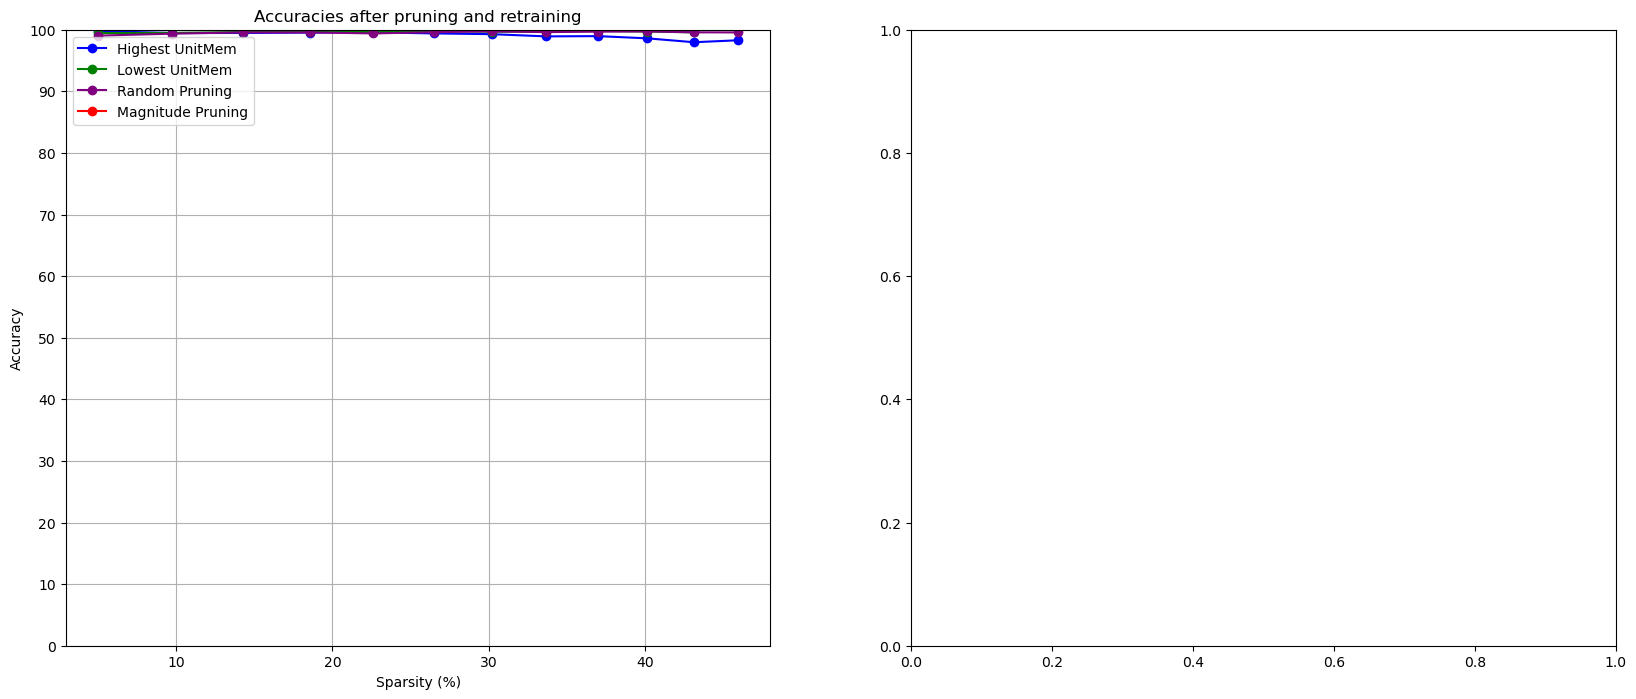

In [3]:
# pass the file path for plotting accuracies
acc_highUM = '/home/ayesha/SparseMem/ayeshas_code/results/exp_0_highUM.txt'
acc_lowUM = '/home/ayesha/SparseMem/ayeshas_code/results/exp_1_LowUM.txt'
acc_hybridUM = '/home/ayesha/SparseMem/ayeshas_code/results/exp_0_rand.txt'
acc_pmag = '/home/ayesha/SparseMem/ayeshas_code/results/exp_0_pmag.txt'

AvgUM_high =  "/home/ayesha/SparseMem/ayeshas_code/results/unitmem/exp__0/Avg_UnitMems_perlevel.json"
AvgUM_low =  "/home/ayesha/SparseMem/ayeshas_code/results/unitmem/exp__1/Avg_UnitMems_perlevel.json"
AvgUM_hybrid =  "/home/ayesha/SparseMem/ayeshas_code/results/random/exp__0/Avg_UnitMems_perlevel.json"
AvgUM_pmag = "/home/ayesha/SparseMem/ayeshas_code/results/pmag/exp__0/Avg_UnitMems_perlevel.json"
title = "Magnitude Pruning vs Highest, Lowest, Random UnitMem Pruning"


plot_combined(AvgUM_high, AvgUM_low, AvgUM_hybrid, AvgUM_pmag, acc_highUM, acc_lowUM, acc_hybridUM ,acc_pmag, title)

In [ ]:
extract_info("/home/ayesha/SparseMem/ayeshas_code/results/exp_14_LowUM_res50.txt")

,level,sparsity,first epoch,last epoch
0,0,5.0,84.47,98.58
